<a href="https://colab.research.google.com/github/wikistat/High-Dimensional-Deep-Learning/blob/master/AutoEncoder/VariationalAutoEncoder_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# Files & Data (Google Colab)

If you're running this notebook on Google colab, you do not have access to the `solutions` folder you get by cloning the repository locally. 

The following lines will allow you to build the folders and the files you need for this TP.

**WARNING 1** Do not run this line localy.
**WARNING 2** The magic command `%load` does not work work on google colab, you will have to copy-paste the solution on the notebook.

In [ ]:
! mkdir image
! wget . https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/vae_mlp_decoder.png
! wget . https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/vae_mlp_vae.png
! wget image https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/image/vae_2.svg
! wget image https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/image/vae_3.svg
! mkdir solutions
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/compare_sparsity_decoded_imgs.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/compare_sparsity_encoded_imgs.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/convolutional_autoencoder.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/decoded_images_both_method.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/decoder_vae.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/generate_single_sample.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/simple_autoencoder.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/vae.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/train_outlier_vae.py
! wget solutions https://github.com/wikistat/High-Dimensional-Deep-Learning/raw/master/AutoEncoder/solutions/error_distribution.py

# High Dimensional & Deep Learning : Variational Autoencoders

## What is a Variational Autoencoder

A variational autoencoder is an autoencoder that learns a latent variable model for its input data.

## Objective

* Build a simple Variational Auto Encoder
* Use Variational Auto Encoder for Number Generation 
* Use Variational Auto Encoder To anomaly detection
* Write a Convolutional Variational Auto Encoder
* Use the Keras Model APi

## Library

In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku

import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

## Data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
input_dim = np.prod(x_train.shape[1:])
n_train = x_train.shape[0]
n_test = x_test.shape[0]
x_train = x_train.reshape((n_train, input_dim))
x_test = x_test.reshape((n_test, input_dim))

## Keras Model API

In the previous TP on image classification of the autoencoder notebook we have used the `Sequential` method to build model.

Sequential Method have limits when the architecture we want is not *linear* or when we want to build a layer on top on two different entries.

The `Model` API can sometimes be less intuitive but is much more flexible than the `Sequential` method. We will use it all along this TP.

## A simple Variational Autoencoders

### Param

In [3]:
# network parameters
n_input = 784
batch_size=100
intermediate_dim = 512
latent_dim = 2
epochs = 25

### Encoder

#### Latent Variable

We first build the encoder part. <br>
It is first composed of  a `Dense` layer with 512 neurons. <br>
Two `Dense` layers are then added on **top of the same layer**. These two layers will produce the two variables *z_mean* and  *z_log_var* in the latent space.

Note that we define each layer as a function of an input which is the output of the layer it follows.

In [4]:
# Input layer
inputs = kl.Input(shape=(n_input,), name='encoder_input')
# Dense layer from input layer
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
# Two dense layer that takes input from the same layer x
z_mean = kl.Dense(latent_dim, name='z_mean')(x)
z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)

### The stochastic latent variable

We use the reparametrization trick to define a random variable z that is conditioned on the input image x as follows:

$$ q(z/x) \sim \mathcal{N}(\mu_z(x), \sigma_z(x)) $$

<img src="image/vae_3.svg" width="600px" />



The reparametrization tricks defines $z$ has follows:

$$ q(z/x) = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_z(x))$ instead of $\sigma_z(x)$. <br>
Taking the exponential of $log(\sigma^2_z(x)$ ensures the positivity of the standard deviation from the raw output of the network.


Let's first define a function that takes as an input the output of the `Z_mean`, and `Z_log_var` previous layer and generate a sample from this input.

In [5]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

Now let's define a keras layer from this function. 

In [6]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

So far we have defined all the layers we need to build the encoder part of the vae. <br> 
We now define the model, with the `Model`method. For that we just have to specify the input layer and the output we want (here, it's the latent variable z). The model is then build automatically.


In [7]:
# instantiate encoder model

encoder = km.Model(inputs, z, name='encoder')
encoder.summary()
#ku.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

### Decoder 

The decoder takes as an input the vector z (which is a sample of the latent distribution define by the encoder). 
It is then composed of 2 Dense layers with the following caracteristics : 

* 512 neurons, relu activation
* 784 neurons (input_shape), sigmoid activation

**Exercise** build this simple decoder model using the Model API

In [22]:
# Récupération de la taille de la sortie de l'encodeur (visuellement accessible avec encoder.summary())
output_layer = encoder.layers[-1]
a = (output_layer.output_shape)[1:] #[1:] enlève le 1er élément

# Input layer
inputs_d = kl.Input(shape = a, name='decoder_input')

# Dense layer from input layer
dense1 = kl.Dense(512, activation='relu')(inputs_d)
dense2 = kl.Dense(n_input, activation='sigmoid')(dense1)

# instantiate decoder model
decoder = km.Model(inputs_d, dense2, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 512)               1536      
                                                                 
 dense_12 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# %load solutions/decoder_vae.py

### Vae

We now associate the encoder and the decoder to define our Variational Autoencoder.

**Exercise** build this VAE model using the Model API

In [24]:
outputs = decoder(encoder(inputs))
vae = km.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        (100, 2)                  403972    
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [27]:
# %load solutions/vae.py

We implement now the vae loss function  as described in the course

$$VAE_{loss} = l(x,\hat{x}) + KL(q(z/x),p(z))$$

$l$ can be any loss function betwen the original image $x$ and the reconstructed image $\hat{x}$. Here we use the binary crossentropy. 


$$ q(z/x) \sim \mathcal{N}(\mu_z(x), \sigma_z(x)), $$
as described below. $p(z)$ is the latent distribution. The easiest choice  is  to take $p(z)\sim \mathcal{N}(0,1)$.


**We first use the following result, that you can check :** 

If $P \sim \mathcal{N}_d(\mu_p, \Sigma_p) $ and $Q \sim \mathcal{N}_d(\mu_q, \Sigma_q) $, then 
$$
KL(Q || P) = \frac{1}{2}\left[\log\frac{|\Sigma_p|}{|\Sigma_q|} - d + \text{tr} \{ \Sigma_p^{-1}\Sigma_q \} + (\mu_p - \mu_q)^T \Sigma_p^{-1}(\mu_p - \mu_q)\right].
$$

In our case, $p(z) \sim \mathcal{N}_2(0,  I_2) $ and $ q(z/x) \sim \mathcal{N}_2(\mu_z(x),\sigma_z(x)) $. Hence, we have

$
KL(q(z/x) || p(z)) = \frac{1}{2}\left[-\log|\sigma_z(x)| - d + \text{tr} \{\sigma_z(x) \} +\mu_z(x)^T \mu_z(x)\right].
$

which can be computed as : 

$KL(q(z/x) || p(z)) = \frac{1}{2} \, \sum_{j=1}^2 \left( \sigma_{z,j}(x) + \mu_{z,j}^2(x) - 1 - \log \sigma_{z,j}(x) \right)$

In [28]:
reconstruction_loss = kloss.binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= n_input
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [29]:
vae.fit(x_train,
                epochs=40,
                batch_size=batch_size,
                validation_data=(x_test, None))

Epoch 1/40
600/600 [==============================] - 16s 25ms/step - loss: 199.1766 - val_loss: 175.2310
Epoch 2/40
600/600 [==============================] - 15s 25ms/step - loss: 171.5461 - val_loss: 167.8904
Epoch 3/40
600/600 [==============================] - 14s 24ms/step - loss: 166.2522 - val_loss: 163.9778
Epoch 4/40
600/600 [==============================] - 15s 24ms/step - loss: 162.8187 - val_loss: 160.8795
Epoch 5/40
600/600 [==============================] - 14s 24ms/step - loss: 160.3896 - val_loss: 159.0792
Epoch 6/40
600/600 [==============================] - 14s 24ms/step - loss: 158.5486 - val_loss: 157.8354
Epoch 7/40
600/600 [==============================] - 14s 23ms/step - loss: 157.1226 - val_loss: 156.6095
Epoch 8/40
600/600 [==============================] - 14s 24ms/step - loss: 155.9100 - val_loss: 155.3543
Epoch 9/40
600/600 [==============================] - 14s 24ms/step - loss: 154.8659 - val_loss: 154.6670
Epoch 10/40
600/600 [=========================

### Display images result

100/100 [==============================] - 1s 9ms/step


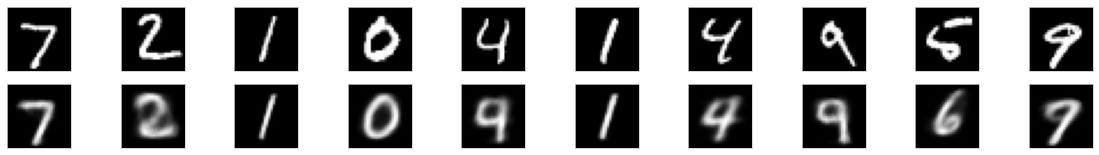

In [31]:
x_test_decoded_vae = vae.predict(x_test, batch_size= batch_size)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Classification of latent variable

100/100 [==============================] - 1s 5ms/step


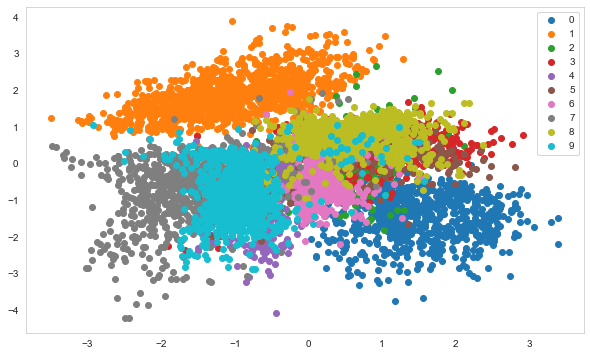

In [32]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1)
for i in range(10):
    x_test_encoded_i = x_test_encoded[y_test==i]
    plt.scatter(x_test_encoded_i[:, 0], x_test_encoded_i[:, 1], label=i)
ax.grid(False)
plt.legend()

plt.show()

## Generation of number

### Single Example

**Exercise** Generate a image number from two random latent variables using the decoder

1/1 [==============================] - 0s 31ms/step


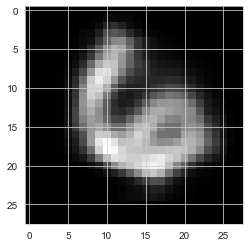

In [49]:
z_latents = np.expand_dims(np.random.normal(0,1,2),axis=0)
x_generate = decoder.predict(z_latents)
plt.imshow(x_generate[0].reshape(28,28))

In [38]:
# %load solutions/generate_single_sample.py

### View of VAE Manifolds

1/1 [==============================] - 0s 16ms/step


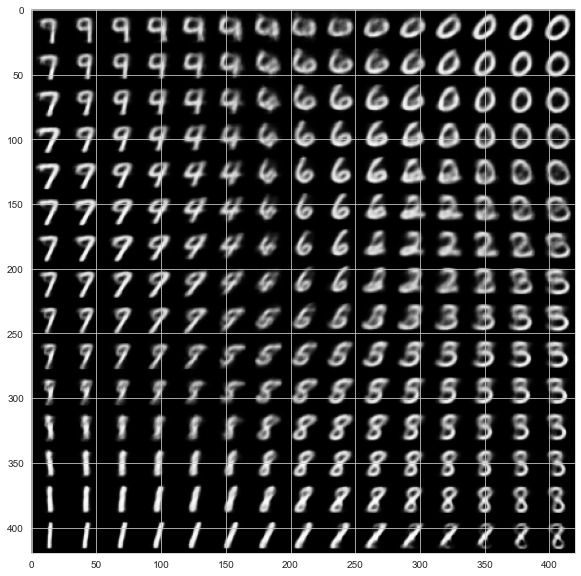

In [50]:
# génère des images à partir de bruit

n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = sc.stats.norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = sc.stats.norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Anomaly Detection

In this part we'll see how variational autoencoder can be used to anomaly detections.

We will consider that 9 images are outliers. 

We will generate four datasets from both train and test dataset, train and test without 9 images and train and test with only 9 images.

In [51]:
outlier_i = 9
x_train_normal = x_train[y_train!=outlier_i]
n_train = x_train_normal.shape[0]-x_train_normal.shape[0]%100
x_train_normal = x_train_normal[:n_train]
x_test_normal =  x_test[y_test!=outlier_i]
n_test = x_test_normal.shape[0]-x_test_normal.shape[0]%100
x_test_normal = x_test_normal[:n_test]

x_train_outliers = x_train[y_train==outlier_i]
n_train = x_train_outliers.shape[0]-x_train_outliers.shape[0]%100
x_train_outliers = x_train_outliers[:n_train]
x_test_outliers =  x_test[y_test==outlier_i]
n_test = x_test_outliers.shape[0]-x_test_outliers.shape[0]%100
x_test_outliers = x_test_outliers[:n_test]

x_train_normal.shape, x_train_outliers.shape, x_test_normal.shape, x_test_outliers.shape

((54000, 784), (5900, 784), (8900, 784), (1000, 784))

**Exervise** Build a VAE as we did above on this notebook and learn weights only on train dataset without 9 images.

In [55]:
# %load solutions/train_outlier_vae.py
# encoder
inputs = kl.Input(shape=(784,), name='encoder_input')
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = kl.Dense(latent_dim, name='z_mean')(x)
z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)
z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder_ad = km.Model(inputs, z, name='encoder')

# decoder
latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(784, activation='sigmoid')(x)
decoder_ad = km.Model(latent_inputs, outputs, name='decoder')

# vae
outputs = decoder_ad(encoder_ad(inputs))
vae_ad = km.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = kloss.binary_crossentropy(inputs,outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_ad.add_loss(vae_loss)
vae_ad.compile(optimizer='adam')

vae_ad.fit(x_train_normal,epochs=epochs, batch_size=batch_size, validation_data=(x_test_normal, None))

Epoch 1/25
540/540 [==============================] - 14s 24ms/step - loss: 203.8444 - val_loss: 179.7783
Epoch 2/25
540/540 [==============================] - 13s 24ms/step - loss: 174.8267 - val_loss: 171.2290
Epoch 3/25
540/540 [==============================] - 14s 25ms/step - loss: 169.1839 - val_loss: 166.9810
Epoch 4/25
540/540 [==============================] - 14s 26ms/step - loss: 165.6600 - val_loss: 164.1936
Epoch 5/25
540/540 [==============================] - 13s 25ms/step - loss: 162.9644 - val_loss: 161.7859
Epoch 6/25
540/540 [==============================] - 13s 24ms/step - loss: 160.9611 - val_loss: 160.3626
Epoch 7/25
540/540 [==============================] - 14s 25ms/step - loss: 159.3678 - val_loss: 158.9733
Epoch 8/25
540/540 [==============================] - 13s 25ms/step - loss: 158.1316 - val_loss: 157.8498
Epoch 9/25
540/540 [==============================] - 13s 25ms/step - loss: 157.1309 - val_loss: 157.3288
Epoch 10/25
540/540 [=========================

### Display decoded image

Let's now try to use our VAE on test dataset with both known numbers (0 to 8) and with outliers (9)

#### Normal Dataset

In [58]:
x_test_decoded_vae = vae_ad.predict(x_test_normal, batch_size=batch_size)

89/89 [==============================] - 1s 7ms/step


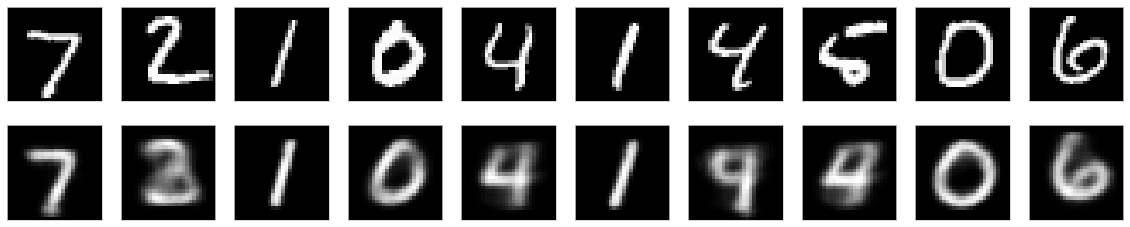

In [57]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_normal[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Outlier Dataset

10/10 [==============================] - 0s 8ms/step


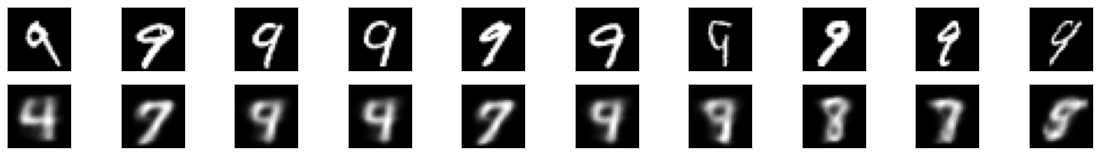

In [59]:
x_test_decoded_vae = vae_ad.predict(x_test_outliers, batch_size=batch_size)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_outliers[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Question** : What can you say about the decoded images in both cases? Is it normal?

On voit que dans le cas d'outliers, le modèle arrive tout de même à reconnaître le n°9 car en réalité, ce chiffre est très proche des données d'entraînement et n'est pas vraiment un outlier. 

### Error Distribution

To evaluate how the detection of 9 images will work, let us check the distribution of the different l2 errors between the original image and their reconstructed image for three types if images:

* Images of know number (0 to 8)
* Images of outlier (9)
* Completly randomly generated images

**Exercise** Generate these distributions

In [62]:
# %load solutions/error_distribution.py
x_test_normal_decoded = vae_ad.predict(x_test_normal, batch_size=batch_size)
error_normal = np.linalg.norm(x_test_normal-x_test_normal_decoded, axis=1)

x_test_outliers_decoded = vae_ad.predict(x_test_outliers, batch_size =batch_size)
error_outliers = np.linalg.norm(x_test_outliers-x_test_outliers_decoded, axis=1)

x_random = np.random.uniform(size=(1000, 784),low=0.0, high=1.0)
x_random_decoded =  vae_ad.predict(x_random, batch_size=batch_size)
error_random = np.linalg.norm(x_random-x_random_decoded, axis=1)


10/10 [==============================] - 0s 7ms/step


C:\Users\coxi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\coxi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\coxi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

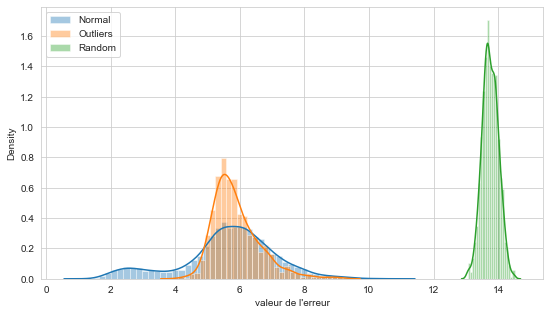

In [63]:
fig=plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,1,1)
sb.distplot(error_normal, ax=ax, label="Normal")
sb.distplot(error_outliers, ax=ax, label="Outliers")
sb.distplot(error_random , ax=ax, label="Random")
plt.xlabel("valeur de l'erreur")
plt.legend()

**Question** What can you say about the error reconstruction of the different cases? What does it say about the performance of VAE to detect anomalies ? 

Comme la gaussienne des outliers est superposée à la gaussienne des observations normales, la grandeur de l'erreur est la même car les outliers (n°9) sont très proches des observations (n°0 à 8). En revanche, l'erreur des données random est beaucoup plus grande. 

## Convolutional Network

**Exercise** You've seen how to build VAE and how to use it to generate new images and to detect anomalies. The VAE used so far only use Dense layer. 

Use CNN layers to build a convolutional VAE and test the different applications (generate images and detect anomalies)

